In [195]:
%load_ext autoreload
%autoreload 2

import torch
# from PolySym import Regressor, Operators
from polysym.torch_operators_2 import Operators
from polysym.regressor import Configurator
from polysym.model import PolySymModel
from polysym.evaluation import r2
from polysym.utils import compile_tree

n_obs = 1000

X3d = torch.zeros((n_obs, 2, 100))
X2d = torch.zeros((n_obs, 1))
y1d = torch.zeros(n_obs)
y2d = torch.zeros(n_obs, 100)

for obs in range(n_obs):

    start, end = torch.rand(2) * 100

    x1 = torch.linspace(start, end, 100)
    x2 = torch.cos(torch.linspace(start, end, 100))
    b = torch.randint(low=-10, high=10, size=(1, 1))

    y = (b + x1 + (x1 * x2))
    # expr=binary_add(binary_add(x0, n0), binary_mul(v1, v0))

    expr = 'binary_add(binary_add(x0, v0), binary_mul(v0, v1))'

    X3d[obs, 0] = x1
    X3d[obs, 1] = x2
    X2d[obs] = b
    y1d[obs] = torch.mean(y).item()
    y2d[obs] = y

operators = Operators(['add', 'sub', 'mul', 'div', 'neg', 'mean'])

model = PolySymModel(X3d=X3d,
                        X2d=X2d,
                        y=y1d,
                        labels_2d=['b'],
                        labels_3d=['vec0', 'vec1'],
                        operators=None,
                        min_complexity=1,
                        max_complexity=4,
                        scale=False,
                        pop_size=300,
                        stopping_criterion=.99,
                        max_iter=5,
                        fitness_fn = r2,
                        fitness_obj = 1,
                        seed=42,
                        verbose=1,
                        optimize_ephemerals=False,
                        workers=1)

#print(model.eval_expr(expr))

# TODO: fix scaling


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
import os, torch, multiprocessing as mp

"""# ---- put this at the top of your main script ----
for var in ("OMP_NUM_THREADS","MKL_NUM_THREADS","OPENBLAS_NUM_THREADS"):
    os.environ[var] = "1"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

if mp.get_start_method(allow_none=True) != "fork":
    mp.set_start_method("fork", force=True)"""   # Linux, CPU‑only
# -----------------------------------------------

model.fit()

2025-04-27 15:37:27,750 - INFO - Running iteration 0/5; best fit=-inf


AttributeError: 'int' object has no attribute 'dim'

In [194]:
model.summary(pretty_print=True)

Best depth=1



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [69]:
sp.pprint(expr)

 10.69⋅v₁                 
────────── + mean(v₀ - v₁)
v₁ + 99.33                


In [46]:
import sympy as sp

sp.sympify(model.best_per_depth[3][1])

locals_map = {
    'binary_add': sp.Add,
    'binary_sub': lambda a, b: a - b,
    'binary_mul': sp.Mul,
    'binary_div': lambda a, b: a / b,
    'unary_neg': lambda x: -x,
    'unary_sin': sp.sin,
    'unary_cos': sp.cos,
    'unary_mean': lambda x: sp.Function('mean')(x),
    'unary_x': lambda x: sp.Function('x')(x)
}

for depth, (fitness, expr, ind) in model.best_per_depth.items():
    # now pass locals_map so sympy knows how to translate
    sym_expr = sp.sympify(expr, locals=locals_map)
    print(f"Depth={depth} fitness={fitness:.2f} ; expr = {sym_expr}")

Depth=1 fitness=0.26 ; expr = v0 + v1
Depth=2 fitness=0.25 ; expr = v0 + v1 + 0.91116815333641
Depth=3 fitness=0.97 ; expr = v0*v1 + v0 + x0
Depth=4 fitness=0.96 ; expr = v0*v1 + v0 - v1 + x0 - 2.44633418120992
Depth=5 fitness=0.95 ; expr = v0*v1 + v0 + v1**2 - v1 + x0
Depth=6 fitness=0.94 ; expr = v0*v1 + v0 + x0 - mean(v1)


In [36]:
model.eval_expr('binary_add(binary_add(x0, v0), binary_mul(v0, v1))')

1.0

In [199]:
import sympy as sp

ind = model.best_per_depth[3][2]
expr = sp.sympify('binary_add(binary_mul(unary_neg(-14), binary_mul(v0, v1)), binary_mul(unary_neg(v0), -14))')

print(expr)
print(sp.simplify(expr))

binary_add(binary_mul(unary_neg(-14), binary_mul(v0, v1)), binary_mul(unary_neg(v0), -14))
binary_add(binary_mul(unary_neg(-14), binary_mul(v0, v1)), binary_mul(unary_neg(v0), -14))


In [11]:
for i in list(model.pset.terminals.values())[0]:
    print(i.name)

print(type(model.pset.terminals))
print(model.pset.terminals)

x0
v0
v1
randc
<class 'collections.defaultdict'>
defaultdict(<class 'list'>, {<class 'object'>: [<deap.gp.Terminal object at 0x139e49440>, <deap.gp.Terminal object at 0x139e4a600>, <deap.gp.Terminal object at 0x139e4aec0>, <class 'deap.gp.randc'>]})


In [169]:
print(model.best_expr)

binary_add(binary_add(x0, v0), binary_mul(v0, v1))


In [30]:
model.depth_quota

{4: np.int64(100), 5: np.int64(100), 6: np.int64(100)}

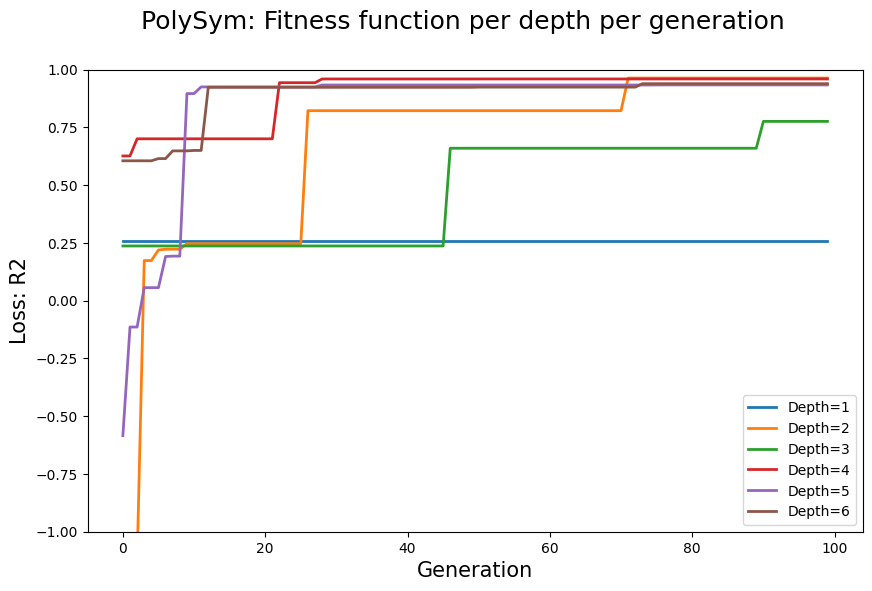

In [171]:
model.plot_differential_loss()

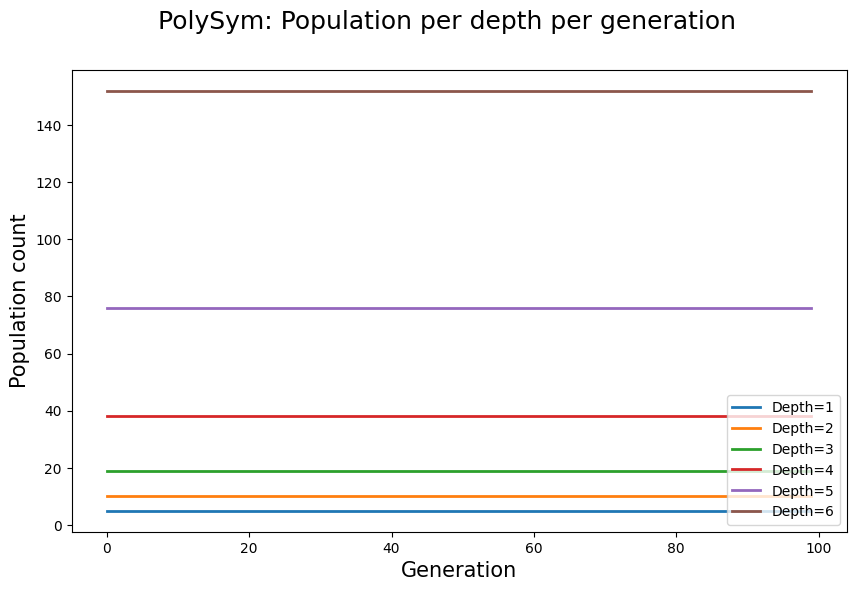

In [172]:
model.plot_depth_per_gen()

In [227]:
from polysym.eval_rank import is_valid_tree

depth = 5
operators = Operators(['add', 'sub', 'mul', 'div', 'neg', 'mean'])
model = PolySymModel(X3d=X3d,
                        X2d=X2d,
                        y=y1d,
                        operators=operators,
                        min_complexity=5,
                        max_complexity=depth,
                        scale=False,
                        pop_size=300,
                        stopping_criterion=.99,
                        max_iter=20,
                        fitness_fn = r2,
                        fitness_obj = 1,
                        seed=42,
                        verbose=1,
                        workers=-1)

pop = model.toolbox.population(n=100)
heights_constraint = [i.height != depth for i in pop]
dim_mismatches = [model.toolbox.evaluate(i)[1] for i in pop]
are_valids = [is_valid_tree(ind, 1) for ind in pop]
any(heights_constraint), any(dim_mismatches), sum(dim_mismatches), sum(are_valids)

(False, False, 0, 100)